In [338]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import pickle
import os
from collections import Counter

In [357]:
case = pd.read_csv('sample_03.csv')

# General Exploration

In [358]:
case.head()

revenue  loyalty  days_since_last_contact gender  \
0        4    -1.33                        2      m   
1        6    -0.28                        3      m   
2        5    -0.22                        1      w   
3        7    -0.29                        0      m   
4        4     1.06                        5      m   

                              person_id  \
0  170636bb-3601-4a18-b572-52650c0d2d0e   
1  2a4c9697-b937-4429-9fd3-5529929a1ab9   
2  4d12441d-3748-4b05-81bf-fd24f9f9d6f4   
3  00f173be-96b1-4407-809c-6882e5bbb1fd   
4  f5aa1643-398f-4027-ab75-7b72ebe92d90   

                             product_ids  0ne.hot.1  0ne.hot.2  0ne.hot.3  \
0  [7881,10834,61603,62040,63288,125830]          1          0          0   
1       [10834,61603,62040,63288,125830]          1          0          0   
2                         [63288,125830]          1          0          0   
3                           [7881,10834]          0          1          0   
4        [7881,10834,62040,63288,125830]          0          0          1   

   0ne.hot.4  
0          0  
1          0  
2          0  
3          0  
4          0

In [97]:
# Look at summary statistics
case.describe()

revenue     loyalty  days_since_last_contact   0ne.hot.1  \
count  100.000000  100.000000               100.000000  100.000000   
mean     6.420000   -0.000090                 6.280000    0.300000   
std      2.527345    1.002703                 3.861438    0.460566   
min      1.000000   -1.710000                 0.000000    0.000000   
25%      5.000000   -0.742500                 3.000000    0.000000   
50%      7.000000   -0.100500                 5.000000    0.000000   
75%      8.250000    1.032500                 9.000000    1.000000   
max     10.000000    1.400000                14.000000    1.000000   

        0ne.hot.2   0ne.hot.3   0ne.hot.4  
count  100.000000  100.000000  100.000000  
mean     0.220000    0.160000    0.320000  
std      0.416333    0.368453    0.468826  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    1.000000  
max      1.000000    1.000000    1.000000

In [98]:
# Check NANs, no missing values anywhere so the data has been prepped in some way
case.isna().sum()

revenue                    0
loyalty                    0
days_since_last_contact    0
gender                     0
person_id                  0
product_ids                0
0ne.hot.1                  0
0ne.hot.2                  0
0ne.hot.3                  0
0ne.hot.4                  0
dtype: int64

In [99]:
case.dtypes

revenue                      int64
loyalty                    float64
days_since_last_contact      int64
gender                      object
person_id                   object
product_ids                 object
0ne.hot.1                    int64
0ne.hot.2                    int64
0ne.hot.3                    int64
0ne.hot.4                    int64
dtype: object

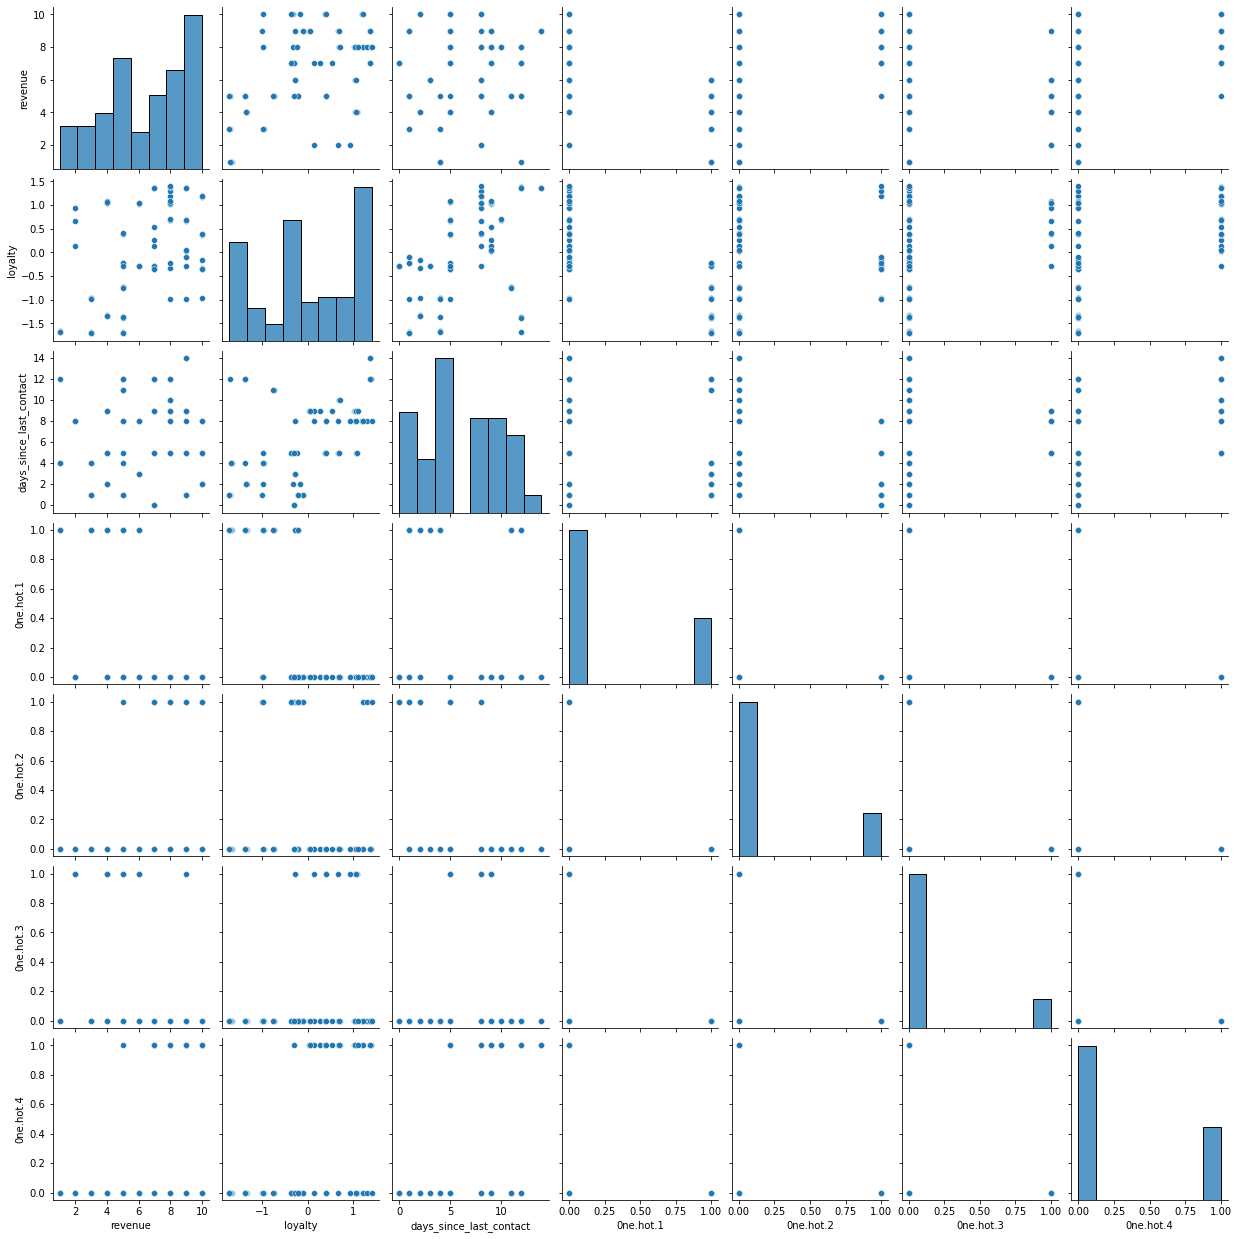

In [100]:
sns.pairplot(case)

In [343]:
# Check Gender Balance
sum(case.gender == 'w')

49

In [362]:
case.corr()

revenue   loyalty  days_since_last_contact  \
revenue                  1.000000  0.460516                 0.157572   
loyalty                  0.460516  1.000000                 0.552121   
days_since_last_contact  0.157572  0.552121                 1.000000   
0ne.hot.1               -0.630006 -0.759576                -0.308974   
0ne.hot.2                0.391285 -0.083962                -0.371709   
0ne.hot.3               -0.333226  0.331683                 0.152783   
0ne.hot.4                0.533317  0.560084                 0.513547   

                         0ne.hot.1  0ne.hot.2  0ne.hot.3  0ne.hot.4  
revenue                  -0.630006   0.391285  -0.333226   0.533317  
loyalty                  -0.759576  -0.083962   0.331683   0.560084  
days_since_last_contact  -0.308974  -0.371709   0.152783   0.513547  
0ne.hot.1                 1.000000  -0.347677  -0.285714  -0.449089  
0ne.hot.2                -0.347677   1.000000  -0.231784  -0.364321  
0ne.hot.3                -0.285714  -0.231784   1.000000  -0.299392  
0ne.hot.4                -0.449089  -0.364321  -0.299392   1.000000

In [348]:
case['gender_binary'] = [int(x) for x in case.gender == 'w']

In [354]:
case[['revenue', 'gender_binary']].groupby('revenue').sum()

gender_binary
revenue               
1                    4
2                    3
3                    3
4                    0
5                   11
6                    0
7                    0
8                   10
9                   12
10                   6

## Each Column

### Revenue

### loyalty

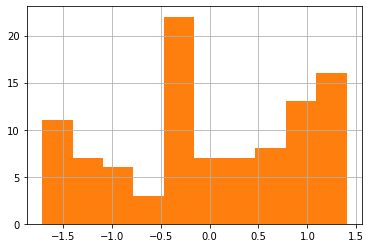

In [101]:
# has mean near zero and standard deviation of 1, but it not normal

case.loyalty.hist()
fig = case.loyalty.hist().get_figure()

#fig.savefig('plots/loyalty_histogram.png')

<AxesSubplot:>

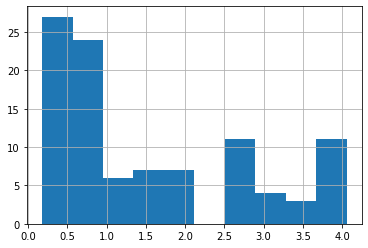

In [356]:
# Check to see if it it was transformed with logarithm
case.loyalty.apply(lambda x: np.exp(x)).hist()

### days_since_last_contact

<AxesSubplot:>

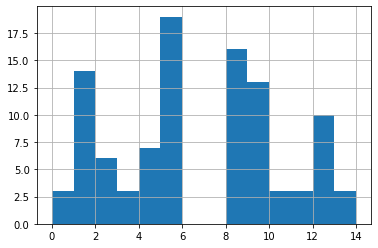

In [85]:
# strangely missing days 7-8, doesn't make sense for a weekly schedule
case.days_since_last_contact.hist(bins=14)

### product_ids

In [80]:
# Check if any list of products contains duplicates
# return 1 if there are two items of the same value
duplicates = lambda x: int(len(x) != len(set(x)))
# any lists with duplicates? 
sum([duplicates(id_list) for id_list in prod_id_lists])

0

<BarContainer object of 6 artists>

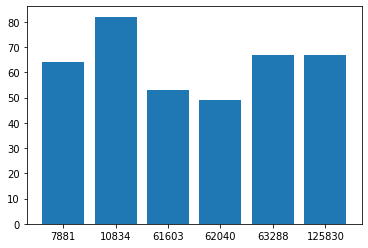

In [316]:
# check to see the distribution of each item across all customers
prod_id_lists = list(map(eval,case.product_ids.to_list()))

flatten = lambda l: [item for sublist in l for item in sublist]

prod_id_flat_list = flatten(prod_id_lists)


cnt = Counter()
for product_id in prod_id_flat_list:
    cnt[str(product_id)] += 1

plt.bar(cnt.keys(),cnt.values())

In [317]:
cnt

Counter({'7881': 64,
         '10834': 82,
         '61603': 53,
         '62040': 49,
         '63288': 67,
         '125830': 67})

In [318]:
possible_IDs = sorted(list(set(prod_id_flat_list)))

In [319]:
possible_IDs

[7881, 10834, 61603, 62040, 63288, 125830]

In [320]:
pickle.dump( possible_IDs, open( "possible_ids.p", "wb" ))

### one hots

In [363]:
# I want to drop the id of people as that will not be useful to create any model, but I want to make sure there are no duplicates first.
case.person_id.duplicated().sum()

0

In [103]:
case = case.drop('person_id',axis=1)

In [298]:
# turn gender into numeric value
# woman will be counted as 1
case.loc[:,'gender'] = case.loc[:,'gender'] == 'w'
case.loc[:,'gender'] = case.loc[:,'gender'].astype('int32')

In [323]:
# convert 
case

revenue  loyalty  days_since_last_contact  gender  \
0         4    -1.33                        2       0   
1         6    -0.28                        3       0   
2         5    -0.22                        1       1   
3         7    -0.29                        0       0   
4         4     1.06                        5       0   
..      ...      ...                      ...     ...   
95        5    -0.22                        1       1   
96        5    -0.29                        5       0   
97        8     1.09                        9       1   
98        1    -1.69                       12       1   
99        3    -1.71                        1       0   

                              product_ids  0ne.hot.1  0ne.hot.2  0ne.hot.3  \
0   [7881,10834,61603,62040,63288,125830]          1          0          0   
1        [10834,61603,62040,63288,125830]          1          0          0   
2                          [63288,125830]          1          0          0   
3                            [7881,10834]          0          1          0   
4         [7881,10834,62040,63288,125830]          0          0          1   
..                                    ...        ...        ...        ...   
95                         [63288,125830]          0          1          0   
96                         [63288,125830]          0          0          0   
97                           [7881,10834]          0          0          0   
98        [7881,10834,62040,63288,125830]          1          0          0   
99                     [7881,10834,61603]          1          0          0   

    0ne.hot.4  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
95          0  
96          1  
97          1  
98          0  
99          0  

[100 rows x 9 columns]

## Add number of items purchased

In [336]:
case["item_count"]=case.product_ids.apply(lambda x:len(eval(x)))

In [337]:
pickle.dump(case,open('Migros/cleaned_data.p',"wb"))